In [1]:
# Import
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from time import time
from PIL import Image
from tqdm import tqdm

import torch
from torch import nn, optim
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.models import mobilenet_v3_small, MobileNet_V3_Small_Weights
from torchsummary import summary
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import kagglehub

In [2]:
#Setep
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")
if device.type == "cuda":
    print(torch.cuda.get_device_name())

Device: cpu


In [3]:
# Load Dataset from KaggleHub
path = kagglehub.dataset_download("phylake1337/fire-dataset")
data_dir = os.path.join(path, "fire_dataset")  # 'fire_images', 'non_fire_images'

print("Dataset Path:", data_dir)
print("Classes:", os.listdir(data_dir))  # ['fire_images', 'non_fire_images']

Dataset Path: C:\Users\anton\.cache\kagglehub\datasets\phylake1337\fire-dataset\versions\1\fire_dataset
Classes: ['fire_images', 'non_fire_images']


In [4]:
# Define Image Transforms
train_transform = transforms.Compose([
    transforms.RandomResizedCrop((224, 224), scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(0.2, 0.2, 0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

In [5]:
# Dataset & Dataloaders
full_ds = ImageFolder(root=data_dir, transform=train_transform)
train_size = int(0.8 * len(full_ds))
test_size = len(full_ds) - train_size
train_ds, test_ds = torch.utils.data.random_split(full_ds, [train_size, test_size])

# Apply test transform to test set
test_ds.dataset.transform = test_transform

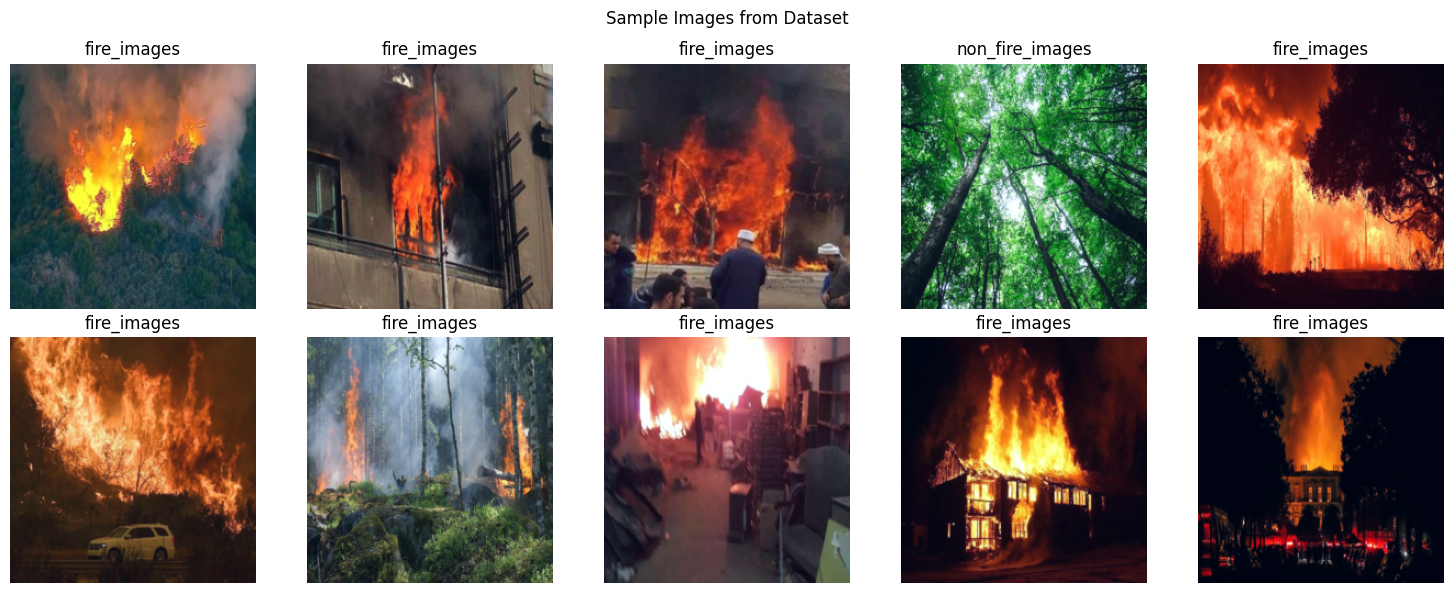

In [6]:
# Show Example Images
def show_samples(dataset, class_names):
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))  # 2 rows, 5 columns
    for i in range(10):
        img, label = dataset[random.randint(0, len(dataset) - 1)]
        img_np = img.permute(1, 2, 0).numpy()
        img_np = np.clip(img_np * 0.229 + 0.485, 0, 1)

        ax = axes[i // 5, i % 5]  # row = i//5, col = i%5
        ax.imshow(img_np)
        ax.set_title(class_names[label])
        ax.axis("off")

    plt.suptitle("Sample Images from Dataset")
    plt.tight_layout()
    plt.show()

show_samples(full_ds, full_ds.classes)

In [7]:
# Class Balancing
targets = [full_ds.targets[i] for i in train_ds.indices]
class_counts = np.bincount(targets)
class_weights = [1.0 / c for c in class_counts]
sample_weights = [class_weights[t] for t in targets]
sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

In [8]:
# Dataloaders
train_loader = DataLoader(train_ds, batch_size=8, sampler=sampler)
test_loader = DataLoader(test_ds, batch_size=8, shuffle=False)

In [9]:
# Model Setup
model = mobilenet_v3_small(weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1)
model.classifier[3] = nn.Linear(model.classifier[3].in_features, len(full_ds.classes))
model = model.to(device)

print("Model Summary:")
summary(model, input_size=(3, 224, 224))

Model Summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 112, 112]             432
       BatchNorm2d-2         [-1, 16, 112, 112]              32
         Hardswish-3         [-1, 16, 112, 112]               0
            Conv2d-4           [-1, 16, 56, 56]             144
       BatchNorm2d-5           [-1, 16, 56, 56]              32
              ReLU-6           [-1, 16, 56, 56]               0
 AdaptiveAvgPool2d-7             [-1, 16, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             136
              ReLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 16, 1, 1]             144
      Hardsigmoid-11             [-1, 16, 1, 1]               0
SqueezeExcitation-12           [-1, 16, 56, 56]               0
           Conv2d-13           [-1, 16, 56, 56]             256
      BatchNorm2d-14    

In [10]:
# Loss, Optimizer, Scheduler
loss_fn = nn.CrossEntropyLoss(weight=torch.tensor(class_weights, dtype=torch.float).to(device))
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3)

In [11]:
# Training Loop
def train_model(model, train_loader, test_loader, epochs=30, patience=5):
    best_acc = 0
    wait = 0
    log = []

    for epoch in range(1, epochs + 1):
        t0 = time()
        model.train()
        train_loss, train_correct, total = 0, 0, 0

        for x, y in tqdm(train_loader, desc=f"Epoch {epoch}"):
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = loss_fn(out, y)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * x.size(0)
            train_correct += (out.argmax(1) == y).sum().item()
            total += y.size(0)

        train_acc = train_correct / total
        train_loss /= total

        # Validation
        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0
        y_true, y_pred = [], []

        with torch.no_grad():
            for x, y in test_loader:
                x, y = x.to(device), y.to(device)
                out = model(x)
                loss = loss_fn(out, y)
                val_loss += loss.item() * x.size(0)
                val_correct += (out.argmax(1) == y).sum().item()
                val_total += y.size(0)
                y_true.extend(y.cpu().numpy())
                y_pred.extend(out.argmax(1).cpu().numpy())

        val_acc = val_correct / val_total
        val_loss /= val_total
        scheduler.step(val_loss)

        report = classification_report(y_true, y_pred, target_names=full_ds.classes, output_dict=True)
        precision = report['weighted avg']['precision']
        recall = report['weighted avg']['recall']
        f1 = report['weighted avg']['f1-score']

        log.append([epoch, train_loss, train_acc, val_loss, val_acc, precision, recall, f1])
        print(f"Epoch {epoch} - Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, F1: {f1:.4f}, Time: {time()-t0:.1f}s")

        if val_acc > best_acc:
            torch.save(model.state_dict(), "best_model.pt")
            best_acc = val_acc
            wait = 0
            print("New best model saved.")
        else:
            wait += 1
            if wait >= patience:
                print("Early stopping triggered.")
                break

    return pd.DataFrame(log, columns=["Epoch", "TrainLoss", "TrainAcc", "ValLoss", "ValAcc", "Precision", "Recall", "F1"])

# Run training
log_df = train_model(model, train_loader, test_loader)
log_df.to_csv("training_log.csv", index=False)

Epoch 1: 100%|██████████| 100/100 [00:55<00:00,  1.79it/s]


Epoch 1 - Train Acc: 0.8360, Val Acc: 0.9600, F1: 0.9606, Time: 62.4s
New best model saved.


Epoch 2: 100%|██████████| 100/100 [00:51<00:00,  1.95it/s]


Epoch 2 - Train Acc: 0.9625, Val Acc: 0.9800, F1: 0.9801, Time: 58.2s
New best model saved.


Epoch 3: 100%|██████████| 100/100 [00:53<00:00,  1.88it/s]


Epoch 3 - Train Acc: 0.9712, Val Acc: 0.9850, F1: 0.9851, Time: 59.2s
New best model saved.


Epoch 4: 100%|██████████| 100/100 [00:41<00:00,  2.43it/s]


Epoch 4 - Train Acc: 0.9800, Val Acc: 0.9800, F1: 0.9801, Time: 46.9s


Epoch 5: 100%|██████████| 100/100 [00:51<00:00,  1.95it/s]


Epoch 5 - Train Acc: 0.9787, Val Acc: 0.9900, F1: 0.9900, Time: 57.0s
New best model saved.


Epoch 6: 100%|██████████| 100/100 [00:39<00:00,  2.55it/s]


Epoch 6 - Train Acc: 0.9900, Val Acc: 0.9850, F1: 0.9851, Time: 43.7s


Epoch 7: 100%|██████████| 100/100 [00:42<00:00,  2.37it/s]


Epoch 7 - Train Acc: 0.9912, Val Acc: 0.9900, F1: 0.9900, Time: 46.1s


Epoch 8: 100%|██████████| 100/100 [00:39<00:00,  2.55it/s]


Epoch 8 - Train Acc: 0.9950, Val Acc: 0.9900, F1: 0.9900, Time: 43.6s


Epoch 9: 100%|██████████| 100/100 [00:37<00:00,  2.67it/s]


Epoch 9 - Train Acc: 0.9975, Val Acc: 0.9900, F1: 0.9900, Time: 42.0s


Epoch 10: 100%|██████████| 100/100 [00:38<00:00,  2.58it/s]


Epoch 10 - Train Acc: 0.9912, Val Acc: 0.9900, F1: 0.9900, Time: 45.3s
Early stopping triggered.


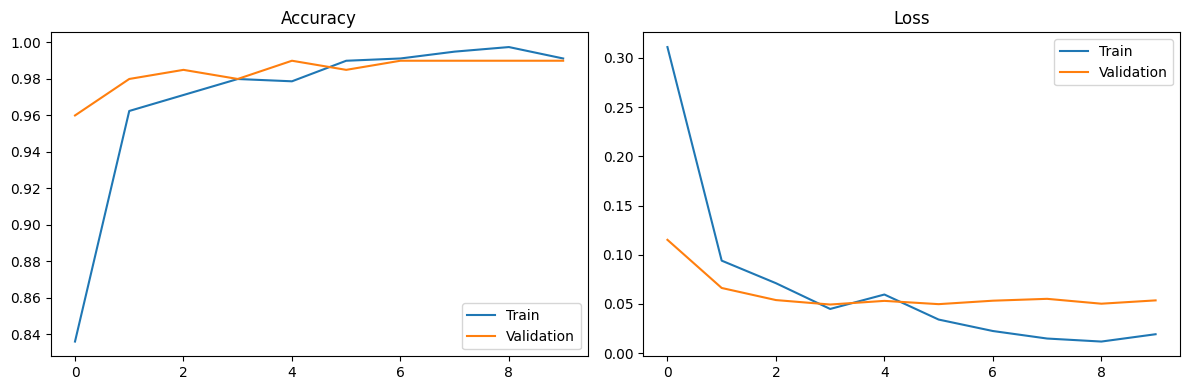

In [12]:
# Plot Accuracy & Loss Curves
def plot_metrics(df):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    axes[0].plot(df["TrainAcc"], label="Train")
    axes[0].plot(df["ValAcc"], label="Validation")
    axes[0].set_title("Accuracy")
    axes[0].legend()

    axes[1].plot(df["TrainLoss"], label="Train")
    axes[1].plot(df["ValLoss"], label="Validation")
    axes[1].set_title("Loss")
    axes[1].legend()

    plt.tight_layout()
    plt.show()

plot_metrics(log_df)

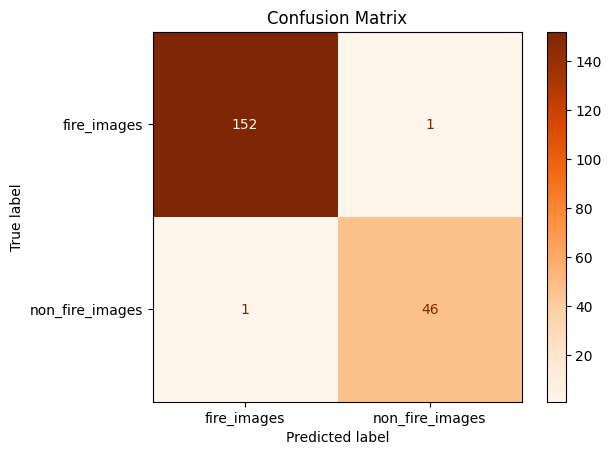

In [13]:
# Confusion Matrix
model.load_state_dict(torch.load("best_model.pt"))
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        out = model(x)
        all_preds.extend(out.argmax(1).cpu().numpy())
        all_labels.extend(y.numpy())

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(cm, display_labels=full_ds.classes)
disp.plot(cmap="Oranges")
plt.title("Confusion Matrix")
plt.show()

In [14]:
# Export to torchscript
torch.jit.save(torch.jit.trace(model, torch.randn(1, 3, 224, 224).to(device)), "mobilenet_fire_scripted.pt")
print("Model exported as TorchScript.")

Model exported as TorchScript.


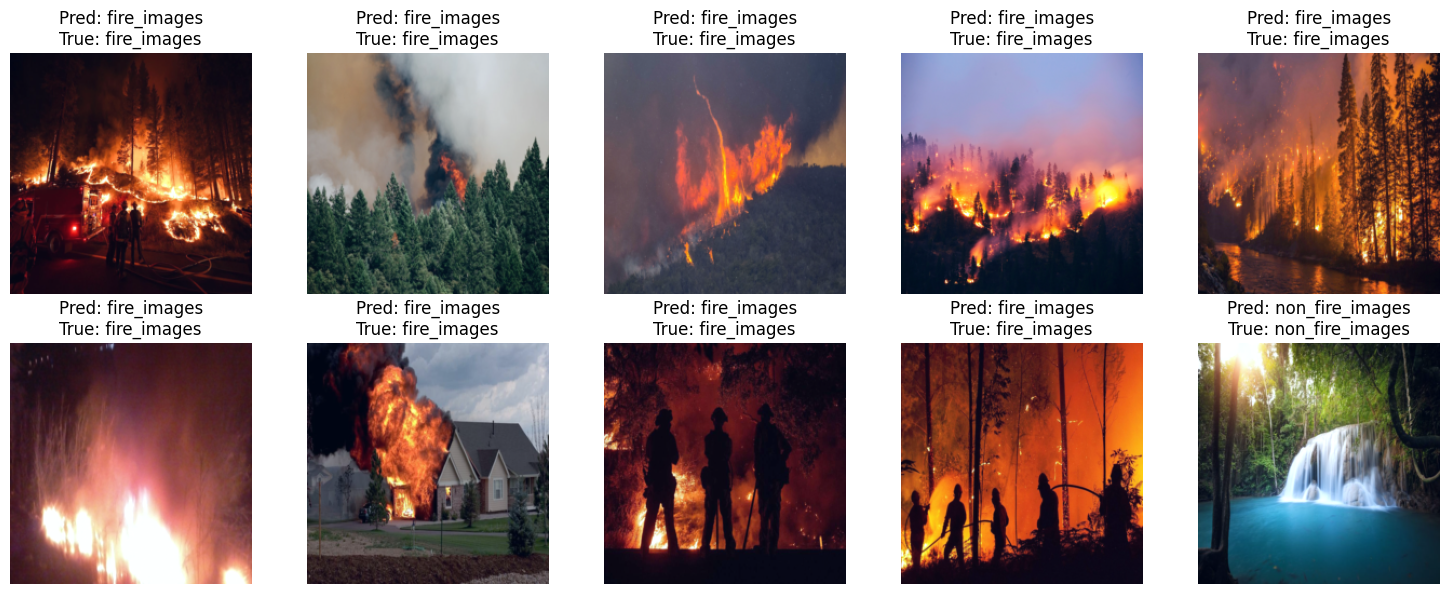

In [15]:
# Show 10 Predictions
def show_predictions(model, dataset, class_names, device, n=10):
    model.eval()
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    with torch.no_grad():
        for i in range(n):
            img, label = dataset[random.randint(0, len(dataset) - 1)]
            input_tensor = img.unsqueeze(0).to(device)
            output = model(input_tensor)
            pred = torch.argmax(output, 1).item()
            img_show = img.permute(1, 2, 0).numpy()
            img_show = np.clip(img_show * 0.229 + 0.485, 0, 1)

            ax = axes[i // 5, i % 5]
            ax.imshow(img_show)
            ax.set_title(f"Pred: {class_names[pred]}\nTrue: {class_names[label]}")
            ax.axis("off")
    plt.tight_layout()
    plt.show()

show_predictions(model, test_ds, full_ds.classes, device)

In [16]:
# Store all predictions and targets
all_preds = []
all_labels = []
misclassified_imgs = []
misclassified_preds = []
misclassified_true = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = outputs.argmax(1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        # Save misclassified examples
        for i in range(len(preds)):
            if preds[i] != labels[i]:
                misclassified_imgs.append(images[i].cpu())
                misclassified_preds.append(preds[i].item())
                misclassified_true.append(labels[i].item())

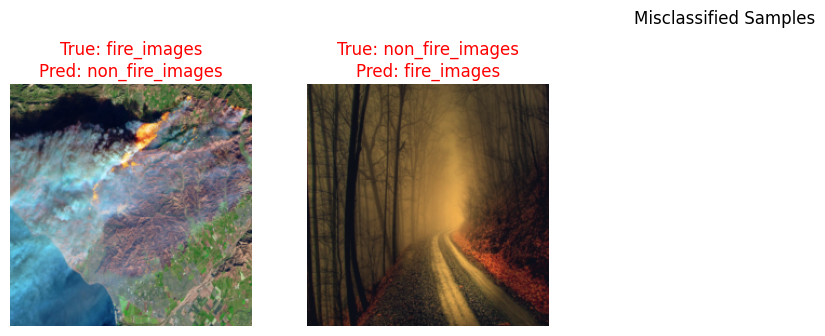

In [17]:
# Identify and visualize misclassified images
def show_misclassified(images, true_labels, pred_labels, class_names, max_display=10):
    plt.figure(figsize=(15, 6))
    for i in range(min(len(images), max_display)):
        img = images[i]
        img = img.permute(1, 2, 0).numpy()
        img = np.clip(img * 0.229 + 0.485, 0, 1)  # De-normalize

        plt.subplot(2, 5, i+1)
        plt.imshow(img)
        plt.title(f"True: {class_names[true_labels[i]]}\nPred: {class_names[pred_labels[i]]}", color="red")
        plt.axis("off")
    plt.suptitle("Misclassified Samples")
    plt.tight_layout()
    plt.show()

# Call the function
show_misclassified(misclassified_imgs, misclassified_true, misclassified_preds, full_ds.classes)

In [18]:
# Predictions on new images
def predict_images_in_folder(folder_path, model, transform, class_names, max_display=20):
    model.eval()
    predictions = []
    fig_rows = (max_display + 4) // 5  # Up to 5 images per row
    fig, axes = plt.subplots(fig_rows, 5, figsize=(15, 3 * fig_rows))

    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    image_files = sorted(image_files)[:max_display]  # Limit display

    class_counter = {cls: 0 for cls in class_names}
    for idx, filename in enumerate(image_files):
        path = os.path.join(folder_path, filename)
        try:
            img = Image.open(path).convert("RGB")
            img_tensor = transform(img).unsqueeze(0).to(device)

            with torch.no_grad():
                output = model(img_tensor)
                pred = output.argmax(1).item()
                pred_class = class_names[pred]
                predictions.append((filename, pred_class))
                class_counter[pred_class] += 1

            # Display image
            img_np = transform(img).permute(1, 2, 0).cpu().numpy()
            img_np = np.clip(img_np * 0.229 + 0.485, 0, 1)

            ax = axes[idx // 5, idx % 5]
            ax.imshow(img_np)
            ax.set_title(f"{filename}\nPred: {pred_class}", fontsize=9)
            ax.axis("off")

        except Exception as e:
            print(f"Failed to process {filename}: {e}")

    # Fill empty subplots
    for i in range(len(image_files), fig_rows * 5):
        fig.delaxes(axes[i // 5, i % 5])

    plt.tight_layout()
    plt.suptitle("Predictions on Test Folder Images", fontsize=14)
    plt.subplots_adjust(top=0.9)
    plt.show()

    print("Class Prediction Summary:")
    for cls, count in class_counter.items():
        print(f"  {cls}: {count} images")

    return predictions

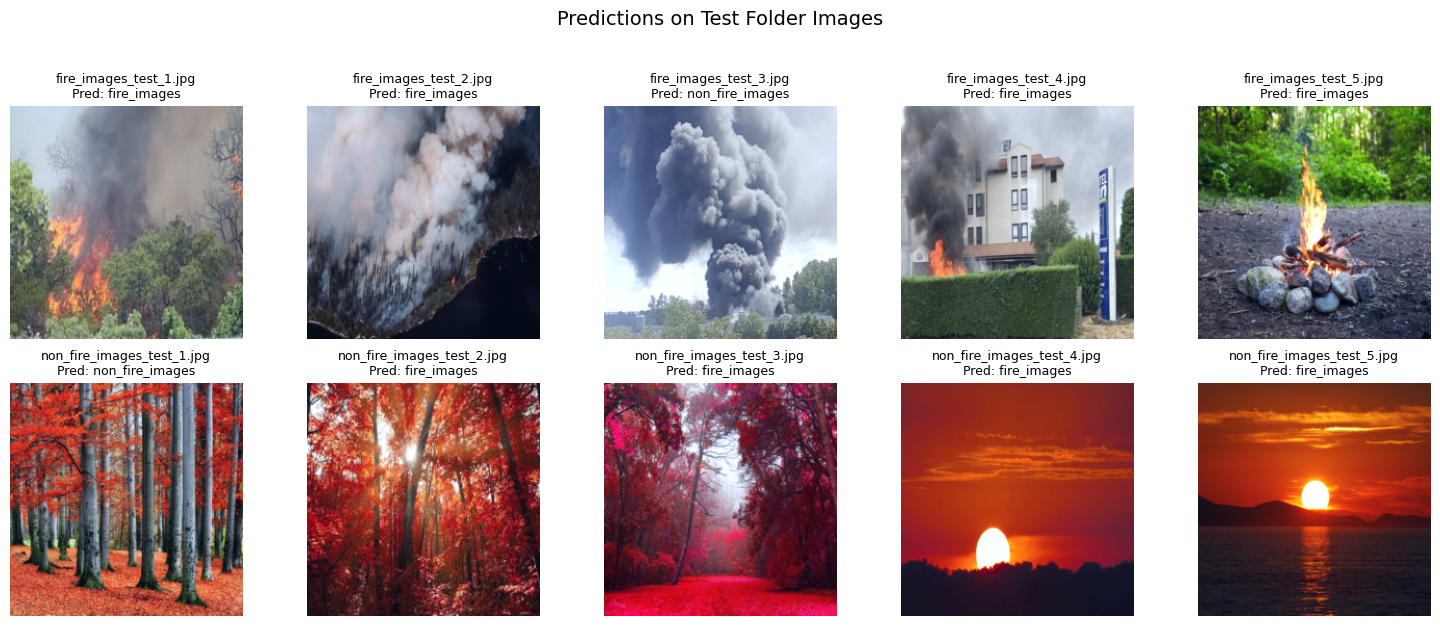

Class Prediction Summary:
  fire_images: 8 images
  non_fire_images: 2 images


In [19]:
# Run
test_folder_path = "./dataset images test"
predictions = predict_images_in_folder(test_folder_path, model, test_transform, full_ds.classes)